In [154]:
import pandas as pd
import numpy as np

In [155]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round4/preprocessed'

In [156]:
%cd ../../../data/round4/preprocessed

/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round4/preprocessed


In [157]:
%ls

day0.csv            day2.csv            mid_price_day0.csv  mid_price_day2.csv
day1.csv            day3.csv            mid_price_day1.csv  mid_price_day3.csv


In [158]:
df_mid_0 = pd.read_csv('mid_price_day0.csv')
df_mid_1 = pd.read_csv('mid_price_day1.csv')
df_mid_2 = pd.read_csv('mid_price_day2.csv')
df_mid_3 = pd.read_csv('mid_price_day3.csv')

In [159]:
df_mid_0['T'] = (7 - df_mid_0['timestamp'] * 0.0001 / 100  ) / 365
df_mid_1['T'] = (6 - df_mid_1['timestamp'] * 0.0001 / 100  ) / 365
df_mid_2['T'] = (5 - df_mid_2['timestamp'] * 0.0001 / 100  ) / 365
df_mid_3['T'] = (4 - df_mid_3['timestamp'] * 0.0001 / 100  ) / 365

In [160]:
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import numpy as np

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, market_price):
    loss_fn = lambda sigma: (bs_call_price(S, K, T, r, sigma) - market_price)**2
    result = minimize_scalar(loss_fn, bounds=(1e-4, 3.0), method='bounded')
    return result.x

def calculate_iv(df):
    df = df.copy()
    strick_prices = [9500, 9750, 10000, 10250, 10500]
    for strick_price in strick_prices:
        df['iv_' + str(strick_price)] = df.apply(lambda row: implied_volatility(
            row['VOLCANIC_ROCK'], strick_price, row['T'], 0, row['VOLCANIC_ROCK_VOUCHER_' + str(strick_price)]), axis=1)
    return df

def calculate_moneyness(df):
    df = df.copy()
    strike_prices = [9500, 9750, 10000, 10250, 10500]
    for strike in strike_prices:
        df[f'm_{strike}'] = df.apply(lambda row: np.log(strike / row['VOLCANIC_ROCK']) / np.sqrt(row['T']), axis=1)
    return df

def fit_iv_curve(df):
    """返回每个时间点 t 的 beta 系数（β₀, β₁, β₂），强制 β₂ ≥ 0"""
    betas = []

    for idx, row in df.iterrows():
        m_values = []
        iv_values = []

        for strike in [9500, 9750, 10000, 10250, 10500]:
            m = row[f'm_{strike}']
            iv = row[f'iv_{strike}']
            if 0 < iv < 2:  # 排除极端值
                m_values.append(m)
                iv_values.append(iv)

        if len(m_values) >= 3:
            # 第一次完整拟合
            X_full = np.column_stack([np.ones(len(m_values)), 
                                    m_values, 
                                    np.square(m_values)])
            beta = np.linalg.lstsq(X_full, iv_values, rcond=None)[0]
            
            # 如果 β₂ < 0，则使用上一组数据
            if beta[2] < 0:
                if len(betas) > 1:
                    beta = betas[-1]
                else:
                    beta = [0,0,0]
        
        else:
            beta = [np.nan, np.nan, np.nan]

        betas.append(beta)

    df[['beta_0', 'beta_1', 'beta_2']] = pd.DataFrame(betas, index=df.index)
    return df


def add_fitted_ivs(df, strike_prices=[9500, 9750, 10000, 10250, 10500]):
    df = df.copy()
    for strike in strike_prices:
        m_col = f'm_{strike}'
        fitted_col = f'fitted_iv_{strike}'
        df[fitted_col] = df.apply(
            lambda row: row['beta_0'] + row['beta_1'] * row[m_col] + row['beta_2'] * row[m_col]**2
            if not np.isnan(row['beta_0']) and not np.isnan(row[m_col]) else np.nan,
            axis=1
        )
    return df

def calculate_base_iv(df):
    df['base_iv'] = df['beta_0']  # 因为在 m = 0 时，β₁·m + β₂·m² 都为0
    return df

In [161]:
def preprocess(df):
    df = df.copy()
    df = calculate_iv(df)
    df = calculate_moneyness(df)
    df = fit_iv_curve(df)
    df = add_fitted_ivs(df)
    df = calculate_base_iv(df)
    return df

In [162]:
df_mid_0 = preprocess(df_mid_0)
df_mid_1 = preprocess(df_mid_1)
df_mid_2 = preprocess(df_mid_2)
df_mid_3 = preprocess(df_mid_3)

In [190]:
df_mid_0.to_csv('day0.csv', index=False)
df_mid_1.to_csv('day1.csv', index=False)
df_mid_2.to_csv('day2.csv', index=False)
df_mid_3.to_csv('day3.csv', index=False)

In [191]:
df_mid_1

,timestamp,day,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,...,m_10500,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv
0,0,1,10516.0,1016.0,766.5,517.5,279.5,95.5,0.016438,0.081794,...,-0.011876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.016438,0.300232,...,-0.011134,0.164007,0.048355,0.276766,0.299217,0.231583,0.187527,0.165350,0.163503,0.164007
2,200,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.016438,0.300234,...,-0.011134,0.164008,0.048355,0.276764,0.299220,0.231585,0.187528,0.165351,0.163504,0.164008
3,300,1,10517.0,1017.5,767.5,519.5,280.5,95.5,0.016438,0.300734,...,-0.012618,0.162297,0.000512,0.216707,0.298252,0.237595,0.195595,0.170913,0.162325,0.162297
4,400,1,10519.5,1019.5,770.5,521.5,282.5,97.5,0.016437,0.081980,...,-0.014472,0.162297,0.000512,0.216707,0.298891,0.238071,0.195911,0.171074,0.162335,0.162297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,1,10224.5,725.5,476.5,237.5,66.5,9.5,0.013700,0.268090,...,0.227161,0.160572,0.003742,0.275953,0.267022,0.204537,0.169791,0.160776,0.175662,0.160572
9996,999600,1,10225.5,725.5,477.5,237.5,66.5,9.5,0.013700,0.070751,...,0.226327,0.160572,0.003742,0.275953,0.267311,0.204722,0.169875,0.160764,0.175554,0.160572
9997,999700,1,10222.0,722.5,472.5,234.5,64.5,9.5,0.013699,0.246240,...,0.229254,0.154998,0.043547,0.284831,0.239304,0.183876,0.156853,0.156171,0.179951,0.154998
9998,999800,1,10223.5,723.5,474.5,237.5,65.5,9.5,0.013699,0.070611,...,0.228003,0.154998,0.043547,0.284831,0.239699,0.184111,0.156932,0.156100,0.179734,0.154998


In [234]:
df0 = pd.read_csv('day0.csv')
df1 = pd.read_csv('day1.csv')
df1['timestamp'] = df1['timestamp'] + 1000000
df2 = pd.read_csv('day2.csv')
df2['timestamp'] = df2['timestamp'] + 2000000
df3 = pd.read_csv('day3.csv')
df3['timestamp'] = df3['timestamp'] + 3000000
df = pd.concat([df0, df1, df2, df3], ignore_index=True)


In [235]:
slice = df1[df1['timestamp'] == 1750000]
slice

,timestamp,day,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,...,m_10500,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv
7500,1750000,1,10305.0,805.0,555.5,313.5,111.5,19.5,0.014384,0.074781,...,0.156306,0.162807,-0.001023,0.221052,0.265175,0.210383,0.176936,0.163293,0.168048,0.162807


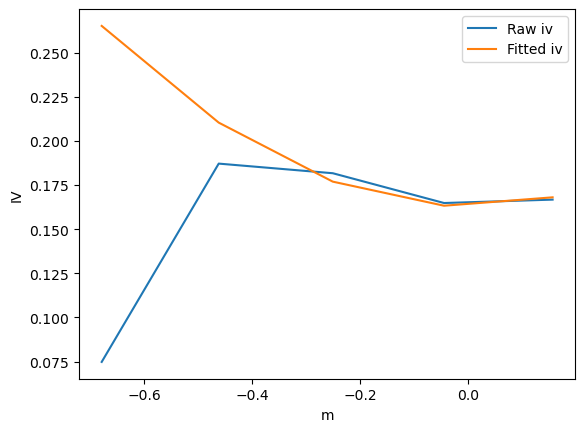

In [236]:
import matplotlib.pyplot as plt
raw_ivs = [slice['iv_9500'], slice['iv_9750'], slice['iv_10000'], slice['iv_10250'], slice['iv_10500']]
ivs = [slice['fitted_iv_9500'], slice['fitted_iv_9750'], slice['fitted_iv_10000'], slice['fitted_iv_10250'], slice['fitted_iv_10500']]
ms = [slice['m_9500'], slice['m_9750'], slice['m_10000'], slice['m_10250'], slice['m_10500']]

plt.plot(ms, raw_ivs, label = 'Raw iv')
plt.plot(ms, ivs, label = 'Fitted iv')
#plt.axhline(y = slice['base_iv'].values[0], color = 'red')
plt.xlabel('m')
plt.ylabel('IV')
plt.legend()

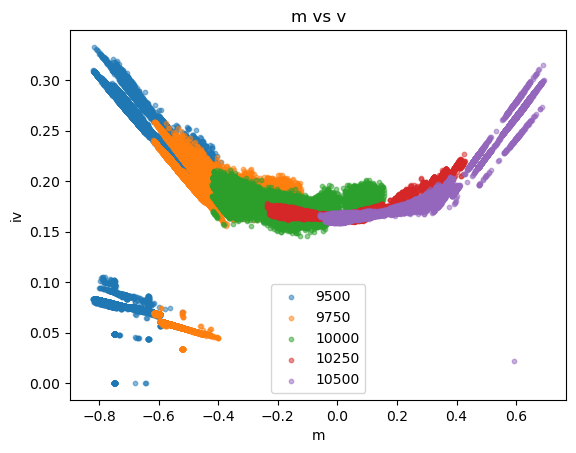

In [237]:
#画出m, iv散点图
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(df['m_9500'], df['iv_9500'], s=10, alpha=0.5, label = '9500')
plt.scatter(df['m_9750'], df['iv_9750'], s=10, alpha=0.5, label = '9750')
plt.scatter(df['m_10000'], df['iv_10000'], s=10, alpha=0.5, label = '10000')
plt.scatter(df['m_10250'], df['iv_10250'], s=10, alpha=0.5, label = '10250')
plt.scatter(df['m_10500'], df['iv_10500'], s=10, alpha=0.5, label = '10500')
plt.title('m vs v')
plt.xlabel('m')
plt.ylabel('iv')
plt.legend()
plt.show()

In [238]:
import numpy as np

def fit_piecewise_vol_surface(m, iv, m1=-0.4, m2=0.4):
    m = np.array(m)
    iv = np.array(iv)

    # 分段
    idx_left = m < m1
    idx_mid = (m >= m1) & (m <= m2)
    idx_right = m > m2

    # 左段：线性拟合
    if np.sum(idx_left) >= 2:
        X_left = np.column_stack([np.ones(np.sum(idx_left)), m[idx_left]])
        beta_left = np.linalg.lstsq(X_left, iv[idx_left], rcond=None)[0]
    else:
        beta_left = [iv[idx_left][0] if np.any(idx_left) else iv[0], 0.0]  # fallback

    # 中段：二次拟合
    if np.sum(idx_mid) >= 3:
        X_mid = np.column_stack([np.ones(np.sum(idx_mid)), m[idx_mid], m[idx_mid]**2])
        beta_mid = np.linalg.lstsq(X_mid, iv[idx_mid], rcond=None)[0]
    else:
        beta_mid = [np.mean(iv[idx_mid]) if np.any(idx_mid) else iv[0], 0.0, 1e-4]

    # 右段：线性拟合
    if np.sum(idx_right) >= 2:
        X_right = np.column_stack([np.ones(np.sum(idx_right)), m[idx_right]])
        beta_right = np.linalg.lstsq(X_right, iv[idx_right], rcond=None)[0]
    else:
        beta_right = [iv[idx_right][0] if np.any(idx_right) else iv[-1], 0.0]

    # 输出三个区域的系数
    return {
        'left': beta_left,
        'mid': beta_mid,
        'right': beta_right,
        'm1': m1,
        'm2': m2,
    }

def predict_piecewise_iv(m_val, coef):
    m1 = coef['m1']
    m2 = coef['m2']

    if m_val < m1:
        b0, b1 = coef['left']
        return b0 + b1 * m_val
    elif m_val > m2:
        b0, b1 = coef['right']
        return b0 + b1 * m_val
    else:
        b0, b1, b2 = coef['mid']
        return b0 + b1 * m_val + b2 * m_val ** 2

0.1453842200429476
Piecewise Vol Surface Coefficients: {'left': array([ 0.07398181, -0.28148283]), 'mid': array([0.16590497, 0.00477699, 0.18775504]), 'right': array([0.06714494, 0.32901553]), 'm1': -0.4, 'm2': 0.4}


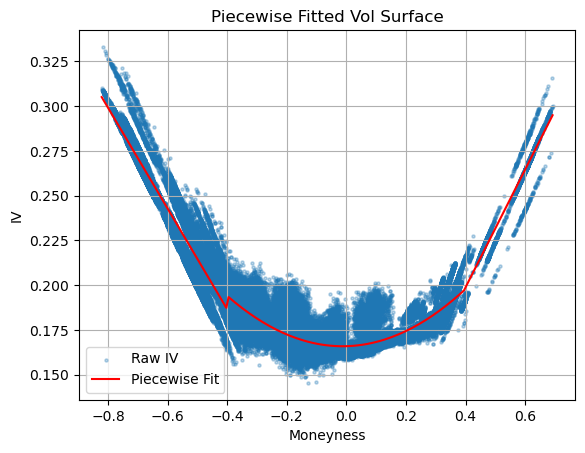

In [239]:
m_all = np.concatenate([
    df['m_9500'].values,
    df['m_9750'].values,
    df['m_10000'].values,
    df['m_10250'].values,
    df['m_10500'].values
])

# 所有 iv 拼接在一起
iv_all = np.concatenate([
    df['iv_9500'].values,
    df['iv_9750'].values,
    df['iv_10000'].values,
    df['iv_10250'].values,
    df['iv_10500'].values
])

mask = iv_all >= 0.125
m_all = m_all[mask]
iv_all = iv_all[mask]
print(min(iv_all))

# 调用函数拟合三段式 smile
vol_surface_coef = fit_piecewise_vol_surface(m_all, iv_all)
print('Piecewise Vol Surface Coefficients:', vol_surface_coef)

# 画原始散点
plt.scatter(m_all, iv_all, s=5, alpha=0.3, label='Raw IV')

# 拟合线：在一系列 m 上计算拟合值
m_range = np.linspace(m_all.min(), m_all.max(), 200)
fitted_iv = [predict_piecewise_iv(m, vol_surface_coef) for m in m_range]

# 画拟合曲线
plt.plot(m_range, fitted_iv, color='red', label='Piecewise Fit')

plt.legend()
plt.xlabel('Moneyness')
plt.ylabel('IV')
plt.title('Piecewise Fitted Vol Surface')
plt.grid(True)
plt.show()

In [240]:
from sklearn.mixture import GaussianMixture
import numpy as np

# 数据准备（reshape 为 GMM 所需格式）
X = df['base_iv'].dropna().values.reshape(-1, 1)

# 用 2 个分布拟合
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# 预测每个时刻的 regime（状态标签）
regimes = gmm.predict(X)

# 将 regime 标签加入原始 df（需要对齐索引）
df = df.loc[df['base_iv'].notnull()].copy()
df['base_iv_regime'] = regimes

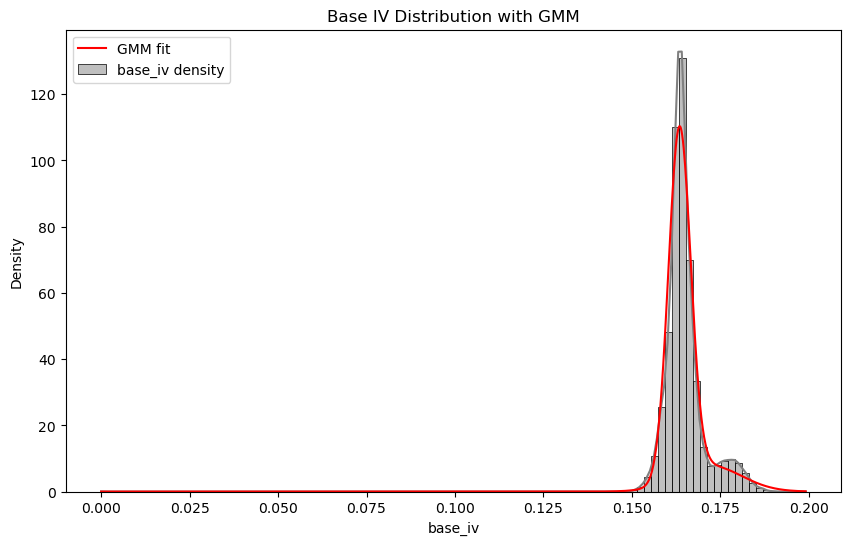

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['base_iv'], bins=100, kde=True, color='gray', stat='density', label='base_iv density')

# 画出 GMM 拟合的两个正态分布
x = np.linspace(df['base_iv'].min(), df['base_iv'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, label='GMM fit', color='red')

plt.title("Base IV Distribution with GMM")
plt.legend()
plt.show()

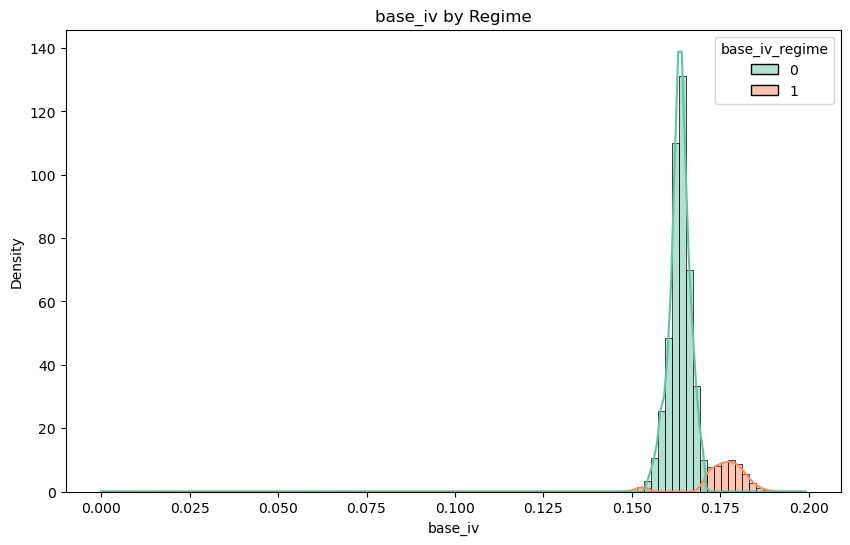

In [242]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='base_iv', hue='base_iv_regime', bins=100, stat='density', kde=True, palette='Set2')
plt.title("base_iv by Regime")
plt.show()

In [265]:
#去除异常iv
columns = ['iv_9500', 'iv_9750', 'iv_10000', 'iv_10250', 'iv_10500']
#如果iv < 0.14，就用最小值0.145代替    
for column in columns:
    df[column] = df[column].apply(lambda x: 0.145 if x < 0.14 else x)


In [285]:
df['delta_iv_9500'] = df['fitted_iv_9500'] - df['iv_9500']
df['delta_iv_9750'] = df['fitted_iv_9750'] - df['iv_9750']
df['delta_iv_10000'] = df['fitted_iv_10000'] - df['iv_10000']
df['delta_iv_10250'] = df['fitted_iv_10250'] - df['iv_10250']
df['delta_iv_10500'] = df['fitted_iv_10500'] - df['iv_10500']

In [286]:
df = df[(abs(df['delta_iv_9500']) < 0.05) & (abs(df['delta_iv_9750']) < 0.1)]


In [287]:
df_regime0 = df[df['base_iv_regime'] == 0]
df_regime1 = df[df['base_iv_regime'] == 1]
#分界线
print(max(df_regime0['base_iv']))
print(len(df_regime0), len(df_regime1))

0.1705821766854664
13789 4215


In [288]:
print(df.columns)

Index(['timestamp', 'VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_9500',
       'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500', 'T',
       'iv_9500', 'iv_9750', 'iv_10000', 'iv_10250', 'iv_10500', 'm_9500',
       'm_9750', 'm_10000', 'm_10250', 'm_10500', 'beta_0', 'beta_1', 'beta_2',
       'fitted_iv_9500', 'fitted_iv_9750', 'fitted_iv_10000',
       'fitted_iv_10250', 'fitted_iv_10500', 'base_iv', 'day',
       'base_iv_regime', 'delta_iv_9500', 'delta_iv_9750', 'delta_iv_10000',
       'delta_iv_10250', 'delta_iv_10500', 'VOLCANIC_ROCK_diff',
       'VOLCANIC_ROCK_vol20'],
      dtype='object')


-0.005819568386311235 -0.0015561779437276158
-0.002585071194626223 0.004751904462125377


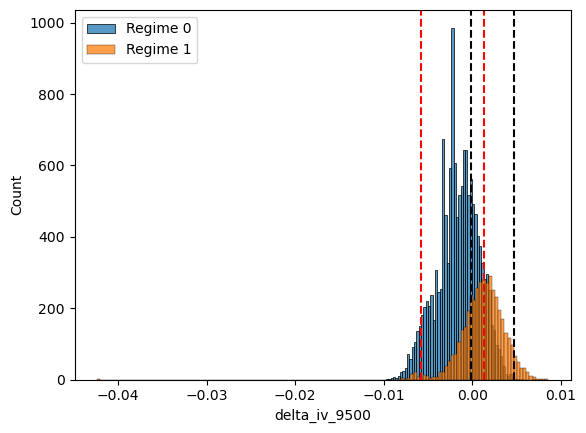

In [289]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_9500'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_9500'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_9500'].quantile(0.05), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_9500'].quantile(0.9), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9500'].quantile(0.25), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9500'].quantile(0.95), color='black', linestyle='--')
print(df_regime0['delta_iv_9500'].quantile(0.05), df_regime0['delta_iv_9500'].quantile(0.5))
print(df_regime1['delta_iv_9500'].quantile(0.05), df_regime1['delta_iv_9500'].quantile(0.95))

plt.legend()

-0.005551109243219121 0.012110007902793169
-0.004417088725731369 0.00010498412960307771


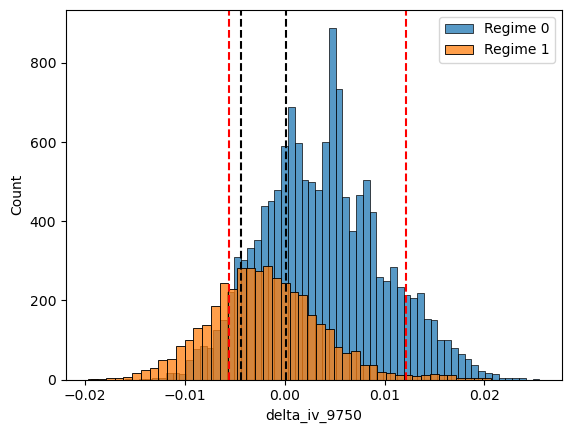

In [290]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_9750'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_9750'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_9750'].quantile(0.05), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_9750'].quantile(0.9), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9750'].quantile(0.33), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_9750'].quantile(0.67), color='black', linestyle='--')
print(df_regime0['delta_iv_9750'].quantile(0.05), df_regime0['delta_iv_9750'].quantile(0.9))
print(df_regime1['delta_iv_9750'].quantile(0.33), df_regime1['delta_iv_9750'].quantile(0.67))
plt.legend()

-0.008639693237308899 0.005459412928400878
-0.008031713501594748 0.004730121439827027


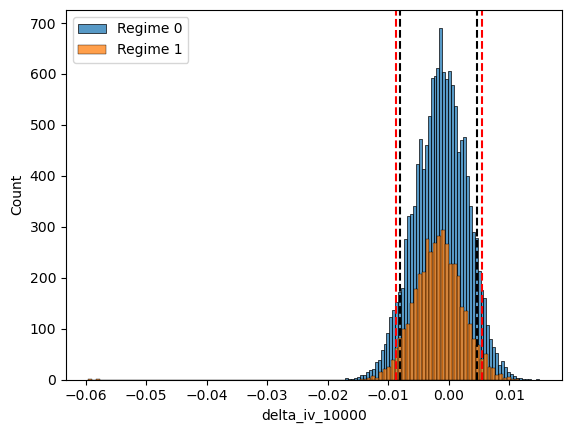

In [291]:
sns.histplot(df_regime0['delta_iv_10000'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10000'], label = 'Regime 1')

plt.axvline(x=df_regime0['delta_iv_10000'].quantile(0.05), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_10000'].quantile(0.95), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10000'].quantile(0.05), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10000'].quantile(0.95), color='black', linestyle='--')
print(df_regime0['delta_iv_10000'].quantile(0.05), df_regime0['delta_iv_10000'].quantile(0.95))
print(df_regime1['delta_iv_10000'].quantile(0.05), df_regime1['delta_iv_10000'].quantile(0.95))

plt.legend()

-0.003291797342303292 -0.0008795939401283933
-0.00033797977424407925 0.009627932260451328


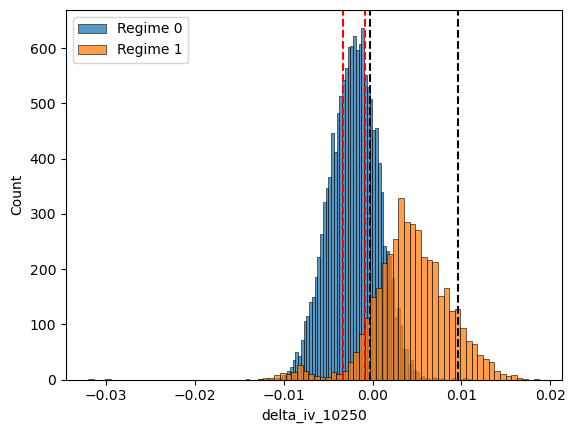

In [292]:
sns.histplot(df_regime0['delta_iv_10250'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10250'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_10250'].quantile(0.33), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_10250'].quantile(0.67), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10250'].quantile(0.1), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10250'].quantile(0.9), color='black', linestyle='--')
print(df_regime0['delta_iv_10250'].quantile(0.33), df_regime0['delta_iv_10250'].quantile(0.67))
print(df_regime1['delta_iv_10250'].quantile(0.1), df_regime1['delta_iv_10250'].quantile(0.9))
plt.legend()

0.0005777207210606849 0.001956874378827377
-0.002800488376230874 -0.0011870381629525654


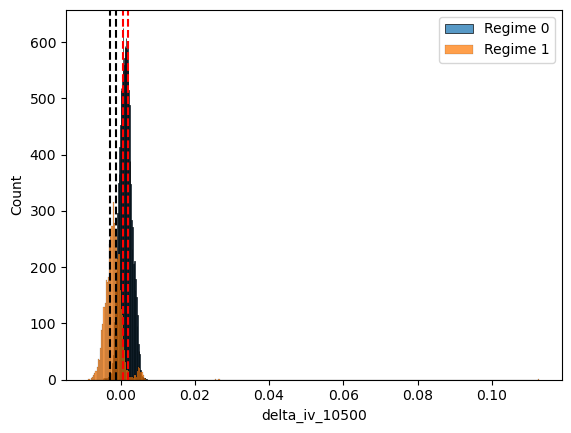

In [294]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_10500'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10500'], label = 'Regime 1')
plt.axvline(x=df_regime0['delta_iv_10500'].quantile(0.33), color='red', linestyle='--')
plt.axvline(x=df_regime0['delta_iv_10500'].quantile(0.67), color='red', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10500'].quantile(0.33), color='black', linestyle='--')
plt.axvline(x=df_regime1['delta_iv_10500'].quantile(0.67), color='black', linestyle='--')
print(df_regime0['delta_iv_10500'].quantile(0.33), df_regime0['delta_iv_10500'].quantile(0.67))
print(df_regime1['delta_iv_10500'].quantile(0.33), df_regime1['delta_iv_10500'].quantile(0.67))

plt.legend()

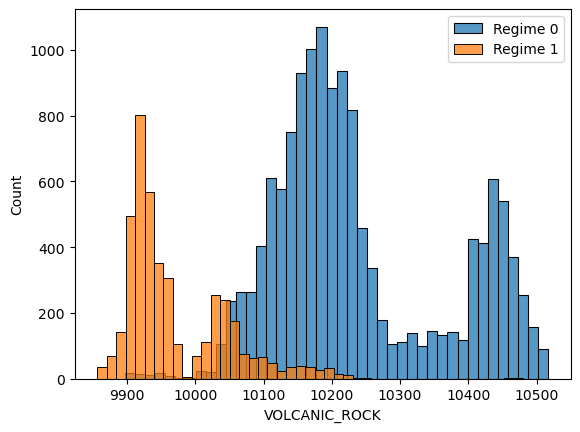

In [295]:
sns.histplot(df_regime0['VOLCANIC_ROCK'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK'], label = 'Regime 1')
plt.legend()

In [253]:
df['VOLCANIC_ROCK_diff'] = df['VOLCANIC_ROCK'] - df['VOLCANIC_ROCK'].shift(1)
df['VOLCANIC_ROCK_vol20'] = df['VOLCANIC_ROCK_diff'].rolling(window=20).std()
df.dropna(inplace = True)

In [254]:
df_regime0 = df[df['base_iv_regime'] == 0]
df_regime1 = df[df['base_iv_regime'] == 1]

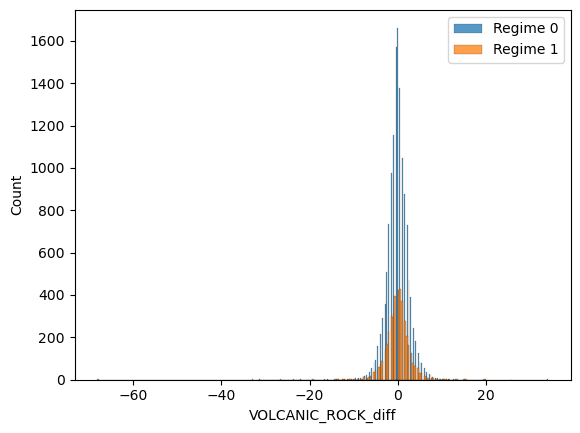

In [296]:
sns.histplot(df_regime0['VOLCANIC_ROCK_diff'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK_diff'], label = 'Regime 1')
plt.legend()

In [297]:
up_quantile = 0.6
down_quantile = 0.4
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime0: {df_regime0['delta_iv_9500'].quantile(down_quantile)}, {df_regime0['delta_iv_9500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime1: {df_regime1['delta_iv_9500'].quantile(down_quantile)}, {df_regime1['delta_iv_9500'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime0: {df_regime0['delta_iv_9750'].quantile(down_quantile)}, {df_regime0['delta_iv_9750'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime1: {df_regime1['delta_iv_9750'].quantile(down_quantile)}, {df_regime1['delta_iv_9750'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime0: {df_regime0['delta_iv_10000'].quantile(down_quantile)}, {df_regime0['delta_iv_10000'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime1: {df_regime1['delta_iv_10000'].quantile(down_quantile)}, {df_regime1['delta_iv_10000'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime0: {df_regime0['delta_iv_10250'].quantile(down_quantile)}, {df_regime0['delta_iv_10250'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime1: {df_regime1['delta_iv_10250'].quantile(down_quantile)}, {df_regime1['delta_iv_10250'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime0: {df_regime0['delta_iv_10500'].quantile(down_quantile)}, {df_regime0['delta_iv_10500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime1: {df_regime1['delta_iv_10500'].quantile(down_quantile)}, {df_regime1['delta_iv_10500'].quantile(up_quantile)}")



0.4, 0.6 quantile of delta_iv_9500 for regime0: -0.002175577812254181, -0.0009082608014730654
0.4, 0.6 quantile of delta_iv_9500 for regime1: 0.0008044564583060909, 0.0018877200986348764
0.4, 0.6 quantile of delta_iv_9750 for regime0: 0.0018639213491665199, 0.005034147840380726
0.4, 0.6 quantile of delta_iv_9750 for regime1: -0.003502739120077941, -0.0009178550395281148
0.4, 0.6 quantile of delta_iv_10000 for regime0: -0.0023353537925110525, -0.0001823189204945235
0.4, 0.6 quantile of delta_iv_10000 for regime1: -0.002666368760112025, -0.0007490639422048417
0.4, 0.6 quantile of delta_iv_10250 for regime0: -0.002753435739953935, -0.0013485170469614842
0.4, 0.6 quantile of delta_iv_10250 for regime1: 0.003381641312182299, 0.005230172933619315
0.4, 0.6 quantile of delta_iv_10500 for regime0: 0.0008623359070331572, 0.001671743624661348
0.4, 0.6 quantile of delta_iv_10500 for regime1: -0.0024296132667503967, -0.001544354930438141


In [298]:
up_quantile = 0.95
down_quantile = 0.05
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime0: {df_regime0['delta_iv_9500'].quantile(down_quantile)}, {df_regime0['delta_iv_9500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9500 for regime1: {df_regime1['delta_iv_9500'].quantile(down_quantile)}, {df_regime1['delta_iv_9500'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime0: {df_regime0['delta_iv_9750'].quantile(down_quantile)}, {df_regime0['delta_iv_9750'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_9750 for regime1: {df_regime1['delta_iv_9750'].quantile(down_quantile)}, {df_regime1['delta_iv_9750'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime0: {df_regime0['delta_iv_10000'].quantile(down_quantile)}, {df_regime0['delta_iv_10000'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10000 for regime1: {df_regime1['delta_iv_10000'].quantile(down_quantile)}, {df_regime1['delta_iv_10000'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime0: {df_regime0['delta_iv_10250'].quantile(down_quantile)}, {df_regime0['delta_iv_10250'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10250 for regime1: {df_regime1['delta_iv_10250'].quantile(down_quantile)}, {df_regime1['delta_iv_10250'].quantile(up_quantile)}")

print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime0: {df_regime0['delta_iv_10500'].quantile(down_quantile)}, {df_regime0['delta_iv_10500'].quantile(up_quantile)}")
print(f"{down_quantile}, {up_quantile} quantile of delta_iv_10500 for regime1: {df_regime1['delta_iv_10500'].quantile(down_quantile)}, {df_regime1['delta_iv_10500'].quantile(up_quantile)}")



0.05, 0.95 quantile of delta_iv_9500 for regime0: -0.005819568386311235, 0.002007790790184394
0.05, 0.95 quantile of delta_iv_9500 for regime1: -0.002585071194626223, 0.004751904462125377
0.05, 0.95 quantile of delta_iv_9750 for regime0: -0.005551109243219121, 0.014477162644477728
0.05, 0.95 quantile of delta_iv_9750 for regime1: -0.010643785724300936, 0.007374360021693459
0.05, 0.95 quantile of delta_iv_10000 for regime0: -0.008639693237308899, 0.005459412928400878
0.05, 0.95 quantile of delta_iv_10000 for regime1: -0.008031713501594748, 0.004730121439827027
0.05, 0.95 quantile of delta_iv_10250 for regime0: -0.006675525476465476, 0.0022477454743635816
0.05, 0.95 quantile of delta_iv_10250 for regime1: -0.0018598575191127785, 0.011254671842374796
0.05, 0.95 quantile of delta_iv_10500 for regime0: -0.0011163641922697697, 0.004065298262960117
0.05, 0.95 quantile of delta_iv_10500 for regime1: -0.00514990406147216, 0.0011108579174534993
